# 決定木とランダムフォレスト分析

説明変数（cpNum, cpNum_range, cpNum_dir, tree）と目的変数の関係を決定木とランダムフォレストで分析します。

## 分析タスク

1. **バグ発見の有無（二値分類）**: 各実行ごとにパラメータからバグ発見確率を予測（ロジスティック回帰分析と同じデータ構造）
2. **5回実行して1回でもバグ発見（二値分類）**: パラメータから5回中1回でもバグ発見がある確率を予測
3. **5回実行して5回全てバグ発見（二値分類）**: パラメータから5回全てバグ発見になる確率を予測


In [1291]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [1292]:
# データ収集関数
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data_for_bug_detection(logs_root='Logs'):
    """
    バグ発見の有無（二値分類）用のデータを収集
    各行（各実行）ごとに1つのデータポイントを作成し、バグ発見の有無を記録
    ロジスティック回帰分析と同じデータ構造
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            
            if not os.path.exists(detected_bugs_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごとにデータポイントを作成）
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    # バグ発見の有無を判定
                    bug_detected = 0  # バグ発見の有無（0: なし, 1: あり）
                    
                    if bug_row == ['timeout']:
                        # タイムアウトの場合はバグ発見なしとして扱う
                        bug_detected = 0
                    elif bug_row == ['null']:
                        # 正常終了の場合はバグ発見なし
                        bug_detected = 0
                    else:
                        # バグ発見
                        bug_detected = 1
                    
                    # データポイントを作成
                    data_records.append({
                        'tree': tree_value,
                        'cpNum': cpnum,
                        'cpNum_range': cpnum_range,
                        'cpNum_dir': cpnum_dir,
                        'bug_detected': bug_detected  # バグ発見の有無（二値）
                    })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\nバグ発見の有無の分布:")
    print(df['bug_detected'].value_counts())
    return df

def collect_data_for_tree_analysis(logs_root='Logs'):
    """
    決定木・ランダムフォレスト用のデータを収集
    パラメータごとに5回実行の結果を集計
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            exe_time_path = param_dir / 'exe_time.csv'
            
            if not os.path.exists(detected_bugs_path) or not os.path.exists(exe_time_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごと）
            bug_results = []
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    if bug_row == ['timeout']:
                        bug_results.append('timeout')
                    elif bug_row == ['null']:
                        bug_results.append('normal')
                    else:
                        bug_results.append('bug')
            
            # 5回実行の結果を集計
            if len(bug_results) >= 5:
                # 最初の5回のみを使用
                first_5_results = bug_results[:5]
                
                # バグ発見の有無（1回でもバグ発見があれば1）
                bug_detected_any = 1 if 'bug' in first_5_results else 0
                
                # 5回全てバグ発見（5回全てbugなら1）
                bug_detected_all = 1 if all(r == 'bug' for r in first_5_results) else 0
                
                # バグ発見回数
                bug_count = sum(1 for r in first_5_results if r == 'bug')
                
                # データポイントを作成
                data_records.append({
                    'tree': tree_value,
                    'cpNum': cpnum,
                    'cpNum_range': cpnum_range,
                    'cpNum_dir': cpnum_dir,
                    'bug_detected_any': bug_detected_any,  # 1回でもバグ発見
                    'bug_detected_all': bug_detected_all,  # 5回全てバグ発見
                    'bug_count': bug_count  # バグ発見回数（0-5）
                })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\n1回でもバグ発見の分布:")
    print(df['bug_detected_any'].value_counts())
    print(f"\n5回全てバグ発見の分布:")
    print(df['bug_detected_all'].value_counts())
    print(f"\nバグ発見回数の分布:")
    print(df['bug_count'].value_counts().sort_index())
    return df

# データ収集
df = collect_data_for_tree_analysis()


データ収集完了: 2160件のレコード

データの基本統計:
              tree        cpNum  cpNum_range    cpNum_dir  bug_detected_any  \
count  2160.000000  2160.000000  2160.000000  2160.000000       2160.000000   
mean    500.000000   225.000000    50.000000     1.150000          0.844444   
std     408.342825   234.059885    40.017597     0.572409          0.362517   
min       0.000000     1.000000     1.000000     1.000000          0.000000   
25%       0.000000    50.000000     1.000000     1.000000          1.000000   
50%     500.000000   149.500000    50.000000     1.000000          1.000000   
75%    1000.000000   300.000000    99.000000     1.000000          1.000000   
max    1000.000000   700.000000    99.000000     4.000000          1.000000   

       bug_detected_all    bug_count  
count       2160.000000  2160.000000  
mean           0.353241     2.881019  
std            0.478087     1.948910  
min            0.000000     0.000000  
25%            0.000000     1.000000  
50%            0.000000

In [ ]:
# モデル評価関数
def evaluate_model(
    y_true, 
    y_pred, 
    y_pred_proba=None, 
    model_name="",
    X_train=None,
    y_train=None,
    X_test=None,
    y_test=None,
    model=None
):
    """
    モデルの評価指標を計算・表示
    
    Args:
        y_true: 正解ラベル（テストデータ）
        y_pred: 予測ラベル（テストデータ）
        y_pred_proba: 予測確率（ROC曲線用、オプション、テストデータ）
        model_name: モデル名
        X_train, y_train: 訓練データ特徴量, ラベル（訓練正解率計算用, オプション）
        X_test, y_test: テストデータ特徴量, ラベル（テスト正解率の真値, オプション）
        model: 学習済みモデル（訓練・テストの正解率計算用, オプション）
    """
    print(f"\n{'='*70}")
    print(f"【{model_name}】評価結果")
    print(f"{'='*70}")
    
    # 混同行列
    cm = confusion_matrix(y_true, y_pred)
    print("\n【混同行列】")
    print(cm)
    
    # 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\n【評価指標】")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # ベースラインモデルの予測を作成
    y_pred_always_bug = np.ones(len(y_true))
    y_pred_always_no_bug = np.zeros(len(y_true))
    
    # ベースラインモデルの評価
    baseline_accuracy = accuracy_score(y_true, y_pred_always_bug)
    baseline_precision = precision_score(y_true, y_pred_always_bug, zero_division=0)
    baseline_recall = recall_score(y_true, y_pred_always_bug, zero_division=0)
    baseline_f1 = f1_score(y_true, y_pred_always_bug, zero_division=0)
    
    print(f"\n【ベースラインモデル】")
    print(f"Accuracy:  {baseline_accuracy:.4f}")
    print(f"Precision: {baseline_precision:.4f}")
    print(f"Recall:    {baseline_recall:.4f}")
    print(f"F1-Score:  {baseline_f1:.4f}")
    print()
    
    # 訓練データとテストデータの正解率出力
    if (model is not None) and (X_train is not None) and (y_train is not None) and (X_test is not None) and (y_test is not None):
        train_acc = y_train.value_counts().get(1, 0) / len(y_train)
        test_acc = y_test.value_counts().get(1, 0) / len(y_test)
        print("訓練データとテストデータの正解率比較")
        print(f"訓練データ正解率: {train_acc:.4f}")
        print(f"テストデータ正解率: {test_acc:.4f}")
    else:
        print("（訓練データ・テストデータの正解率を表示するには model, X_train, y_train, X_test, y_test をすべて渡してください）")
    
    # ROC曲線とAUC（予測確率が利用可能な場合）
    if y_pred_proba is not None:
        try:
            auc_score = roc_auc_score(y_true, y_pred_proba)
            print(f"AUC:       {auc_score:.4f}")
            
            # ROC曲線を描画
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Random')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        except Exception as e:
            print(f"AUC計算エラー: {e}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }


## タスク0: バグ発見の有無（二値分類）

各実行ごとにパラメータからバグ発見の有無を予測します（ロジスティック回帰分析と同じデータ構造）。


In [1294]:
# タスク0: バグ発見の有無（二値分類）の予測

# 各実行ごとのデータを収集
df_bug_detection = collect_data_for_bug_detection()

# 特徴量と目的変数の準備
X0 = df_bug_detection[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y0 = df_bug_detection['bug_detected']

# 訓練データとテストデータに分割
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0, y0, test_size=0.3, random_state=42, stratify=y0
)

print(f"訓練データ数: {len(X0_train)}")
print(f"テストデータ数: {len(X0_test)}")
print(f"\n訓練データの目的変数分布:")
print(y0_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y0_test.value_counts())


データ収集完了: 10800件のレコード

データの基本統計:
               tree         cpNum   cpNum_range     cpNum_dir  bug_detected
count  10800.000000  10800.000000  10800.000000  10800.000000  10800.000000
mean     500.000000    225.000000     50.000000      1.150000      0.576204
std      408.267192    234.016532     40.010185      0.572303      0.494182
min        0.000000      1.000000      1.000000      1.000000      0.000000
25%        0.000000     50.000000      1.000000      1.000000      0.000000
50%      500.000000    149.500000     50.000000      1.000000      1.000000
75%     1000.000000    300.000000     99.000000      1.000000      1.000000
max     1000.000000    700.000000     99.000000      4.000000      1.000000

バグ発見の有無の分布:
bug_detected
1    6223
0    4577
Name: count, dtype: int64
訓練データ数: 7560
テストデータ数: 3240

訓練データの目的変数分布:
bug_detected
1    4356
0    3204
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected
1    1867
0    1373
Name: count, dtype: int64



【決定木（バグ発見の有無）】評価結果

【混同行列】
[[1157  216]
 [ 310 1557]]

【評価指標】
Accuracy:  0.8377
Precision: 0.8782
Recall:    0.8340
F1-Score:  0.8555

【ベースラインモデル】
Accuracy:  0.5762
Precision: 0.5762
Recall:    1.0000
F1-Score:  0.7312

訓練データとテストデータの正解率比較
訓練データ正解率: 0.5762
テストデータ正解率: 0.5762
AUC:       0.8605


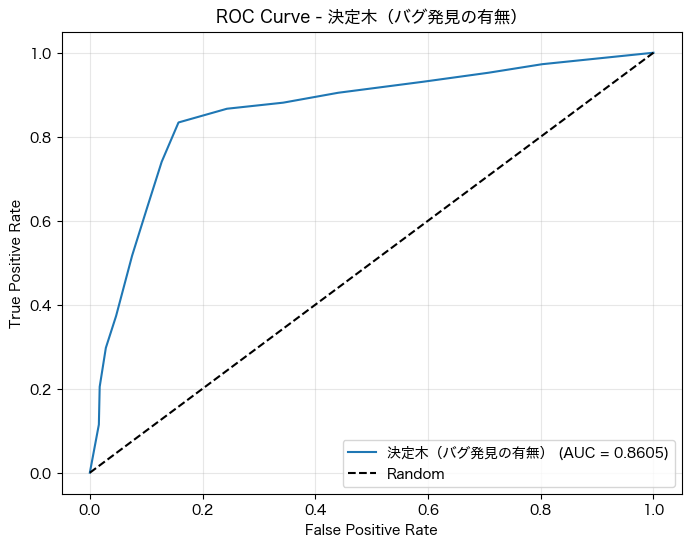

In [1295]:
# 決定木モデルの訓練と評価（タスク0）
dt_model0 = DecisionTreeClassifier(
    max_depth=None,
    # min_samples_split=20,
    min_samples_leaf=0.05,
    random_state=42
)
dt_model0.fit(X0_train, y0_train)

# 予測
y0_pred_dt = dt_model0.predict(X0_test)
y0_pred_proba_dt = dt_model0.predict_proba(X0_test)[:, 1]

# 評価
dt_results0 = evaluate_model(y0_test, y0_pred_dt, y0_pred_proba_dt, "決定木（バグ発見の有無）", X0_train, y0_train, X0_test, y0_test, dt_model0)



【決定木】特徴量重要度（バグ発見の有無）
       feature  importance
2  cpNum_range    0.676155
1        cpNum    0.321007
0         tree    0.002838
3    cpNum_dir    0.000000


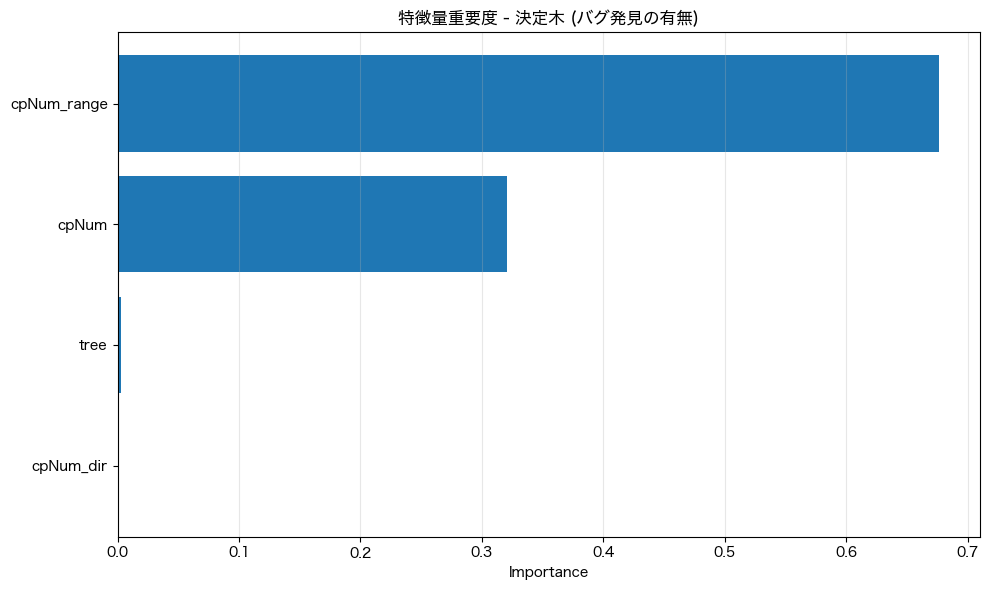

In [1296]:
# 決定木の特徴量重要度（タスク0）
feature_importance_dt0 = pd.DataFrame({
    'feature': X0.columns,
    'importance': dt_model0.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【決定木】特徴量重要度（バグ発見の有無）")
print(feature_importance_dt0)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_dt0['feature'], feature_importance_dt0['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - 決定木 (バグ発見の有無)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


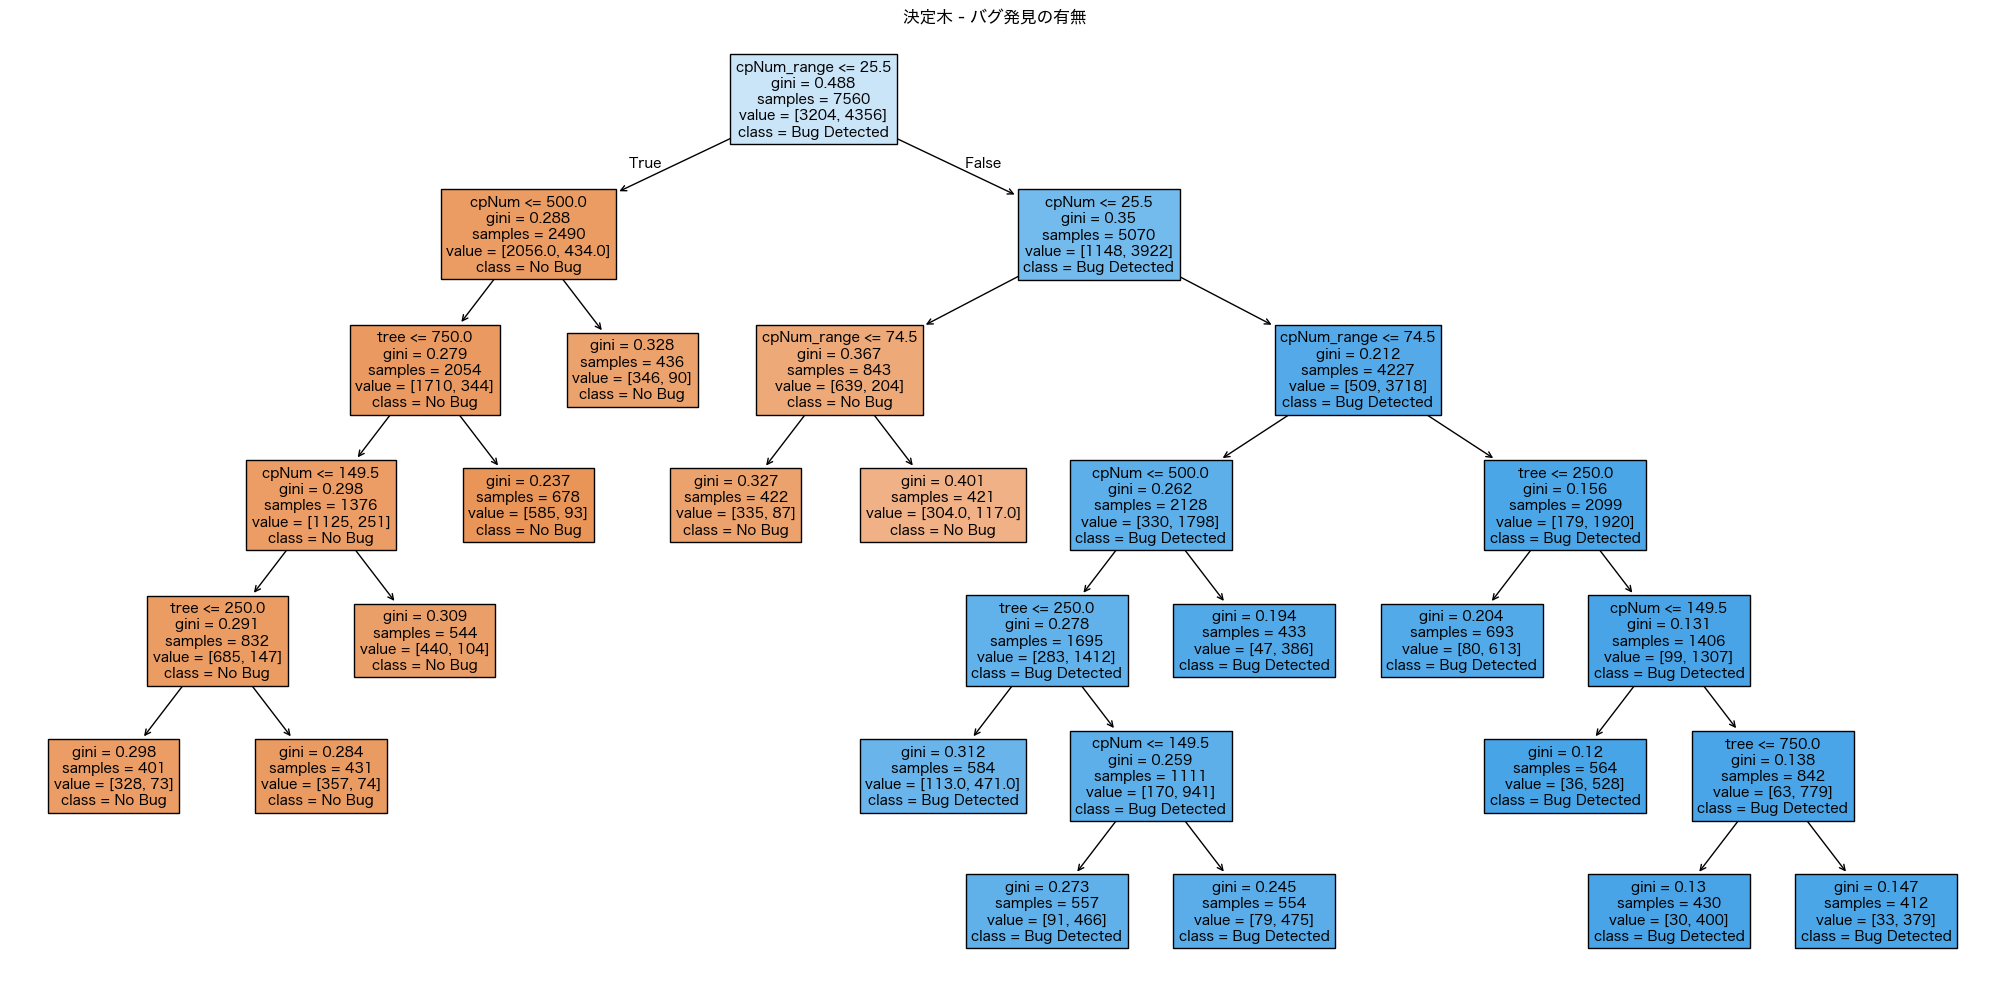

In [1297]:
# 決定木の可視化（タスク0 - 深さ3まで表示）
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model0,
    feature_names=X0.columns,
    class_names=['No Bug', 'Bug Detected'],
    max_depth=None,
    filled=True,
    fontsize=10
)
plt.title('決定木 - バグ発見の有無')
plt.tight_layout()
plt.show()



【ランダムフォレスト（バグ発見の有無）】評価結果

【混同行列】
[[1147  226]
 [ 309 1558]]

【評価指標】
Accuracy:  0.8349
Precision: 0.8733
Recall:    0.8345
F1-Score:  0.8535

【ベースラインモデル】
Accuracy:  0.5762
Precision: 0.5762
Recall:    1.0000
F1-Score:  0.7312

訓練データとテストデータの正解率比較
訓練データ正解率: 0.5762
テストデータ正解率: 0.5762
AUC:       0.8608


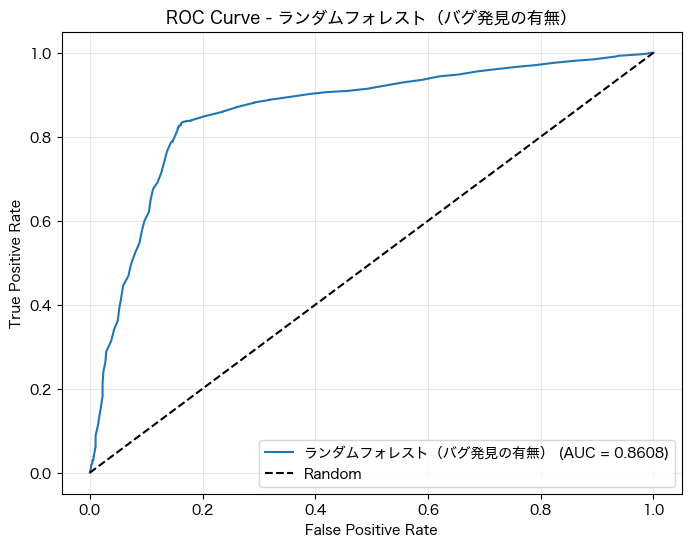

In [1298]:
# ランダムフォレストモデルの訓練と評価（タスク0）
rf_model0 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model0.fit(X0_train, y0_train)

# 予測
y0_pred_rf = rf_model0.predict(X0_test)
y0_pred_proba_rf = rf_model0.predict_proba(X0_test)[:, 1]

# 評価
rf_results0 = evaluate_model(y0_test, y0_pred_rf, y0_pred_proba_rf, "ランダムフォレスト（バグ発見の有無）", X0_train, y0_train, X0_test, y0_test, rf_model0)



【ランダムフォレスト】特徴量重要度（バグ発見の有無）
       feature  importance
2  cpNum_range    0.689827
1        cpNum    0.277172
3    cpNum_dir    0.020037
0         tree    0.012965


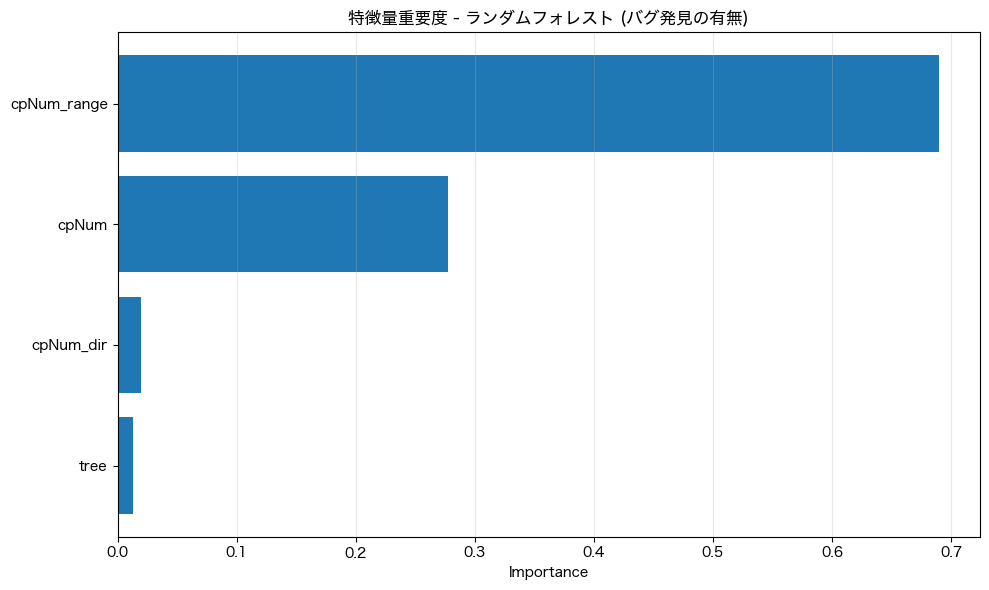

In [1299]:
# ランダムフォレストの特徴量重要度（タスク0）
feature_importance_rf0 = pd.DataFrame({
    'feature': X0.columns,
    'importance': rf_model0.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【ランダムフォレスト】特徴量重要度（バグ発見の有無）")
print(feature_importance_rf0)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf0['feature'], feature_importance_rf0['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - ランダムフォレスト (バグ発見の有無)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



【タスク0: バグ発見の有無（二値分類）】モデル比較
                決定木  ランダムフォレスト
Accuracy   0.837654   0.834877
Precision  0.878173   0.873318
Recall     0.833958   0.834494
F1-Score   0.855495   0.853465


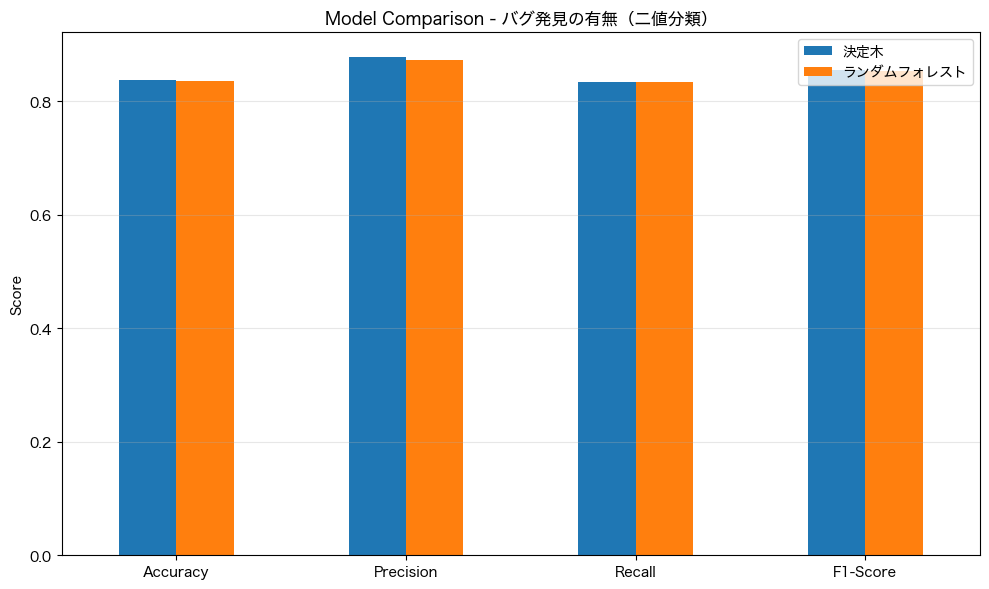

In [1300]:
# タスク0の結果比較
comparison_task0 = pd.DataFrame({
    '決定木': [
        dt_results0['accuracy'],
        dt_results0['precision'],
        dt_results0['recall'],
        dt_results0['f1']
    ],
    'ランダムフォレスト': [
        rf_results0['accuracy'],
        rf_results0['precision'],
        rf_results0['recall'],
        rf_results0['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク0: バグ発見の有無（二値分類）】モデル比較")
print(comparison_task0)

# 可視化
comparison_task0.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - バグ発見の有無（二値分類）')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## タスク1: 5回実行して1回でもバグ発見の予測


In [1301]:
# タスク1: バグ発見の有無（1回でもバグ発見）の予測

# 特徴量と目的変数の準備
X1 = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y1 = df['bug_detected_any']

# 訓練データとテストデータに分割
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.3, random_state=42, stratify=y1
)

print(f"訓練データ数: {len(X1_train)}")
print(f"テストデータ数: {len(X1_test)}")
print(f"\n訓練データの目的変数分布:")
print(y1_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y1_test.value_counts())


訓練データ数: 1512
テストデータ数: 648

訓練データの目的変数分布:
bug_detected_any
1    1277
0     235
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected_any
1    547
0    101
Name: count, dtype: int64



【決定木（1回でもバグ発見）】評価結果

【混同行列】
[[ 91  10]
 [149 398]]

【評価指標】
Accuracy:  0.7546
Precision: 0.9755
Recall:    0.7276
F1-Score:  0.8335

【ベースラインモデル】
Accuracy:  0.8441
Precision: 0.8441
Recall:    1.0000
F1-Score:  0.9155

訓練データとテストデータの正解率比較
訓練データ正解率: 0.8446
テストデータ正解率: 0.8441
AUC:       0.8515


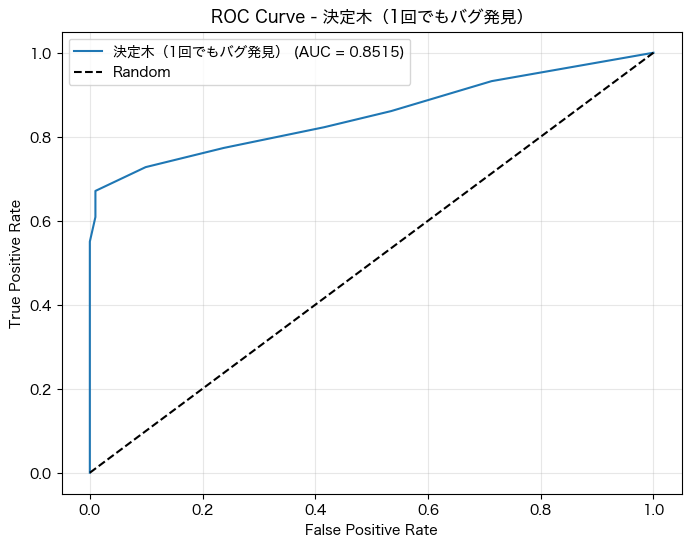

In [1302]:
# 決定木モデルの訓練と評価（タスク1）
dt1_model = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.05,
    random_state=42,
    class_weight='balanced'
)
dt1_model.fit(X1_train, y1_train)

# 予測
y1_pred_dt = dt1_model.predict(X1_test)
y1_pred_proba_dt = dt1_model.predict_proba(X1_test)[:, 1]

# 評価
dt1_results = evaluate_model(y1_test, y1_pred_dt, y1_pred_proba_dt, "決定木（1回でもバグ発見）", X1_train, y1_train, X1_test, y1_test, dt1_model)



【決定木】特徴量重要度（1回でもバグ発見）
       feature  importance
2  cpNum_range    0.657196
1        cpNum    0.338811
0         tree    0.003992
3    cpNum_dir    0.000000


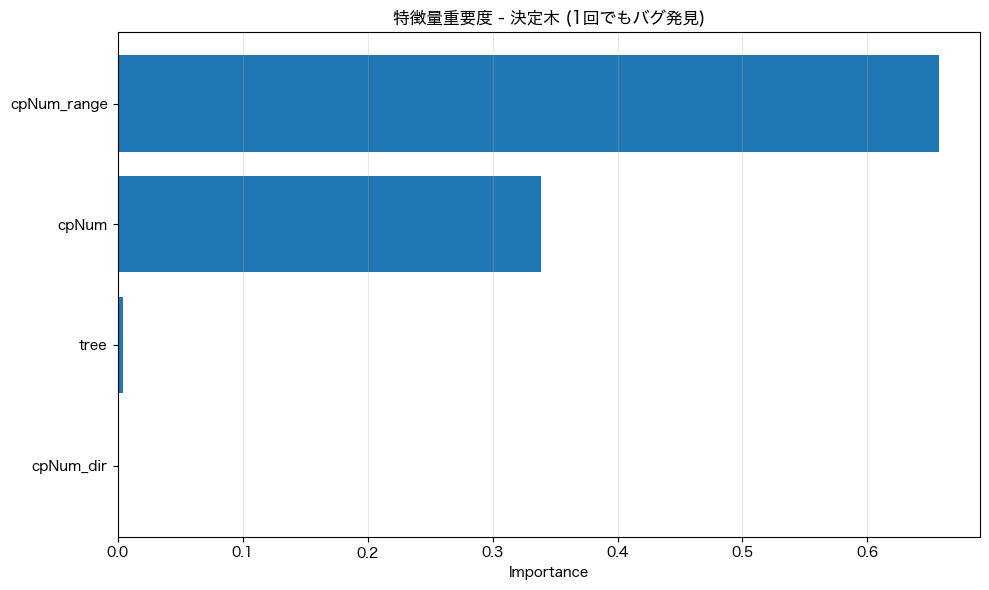

In [1303]:
# 決定木の特徴量重要度（タスク1）
feature_importance_dt1 = pd.DataFrame({
    'feature': X1.columns,
    'importance': dt1_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【決定木】特徴量重要度（1回でもバグ発見）")
print(feature_importance_dt1)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_dt1['feature'], feature_importance_dt1['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - 決定木 (1回でもバグ発見)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


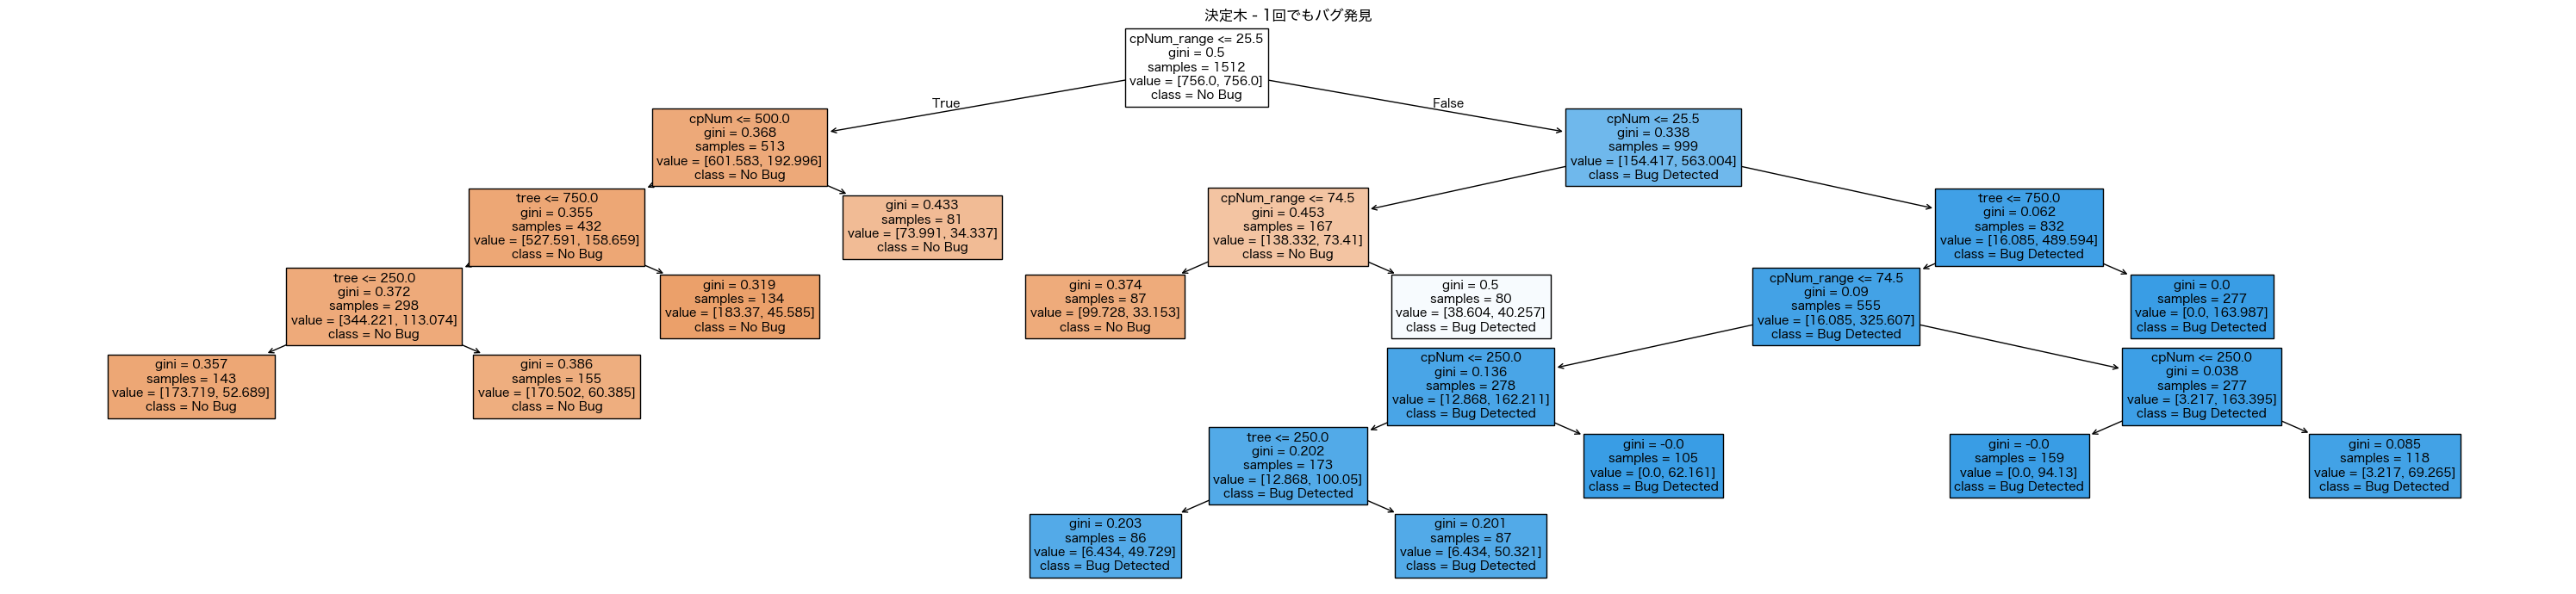

In [1304]:
# 決定木の可視化（タスク0 - 深さ3まで表示）
plt.figure(figsize=(30, 7))
plot_tree(
    dt1_model,
    feature_names=X1.columns,
    class_names=['No Bug', 'Bug Detected'],
    max_depth=None,
    filled=True,
    fontsize=10
)
plt.title('決定木 - 1回でもバグ発見')
plt.tight_layout()
plt.show()


【ランダムフォレスト（1回でもバグ発見）】評価結果

【混同行列】
[[  8  93]
 [ 21 526]]

【評価指標】
Accuracy:  0.8241
Precision: 0.8498
Recall:    0.9616
F1-Score:  0.9022

【ベースラインモデル】
Accuracy:  0.8441
Precision: 0.8441
Recall:    1.0000
F1-Score:  0.9155

訓練データとテストデータの正解率比較
訓練データ正解率: 0.8446
テストデータ正解率: 0.8441
AUC:       0.8504


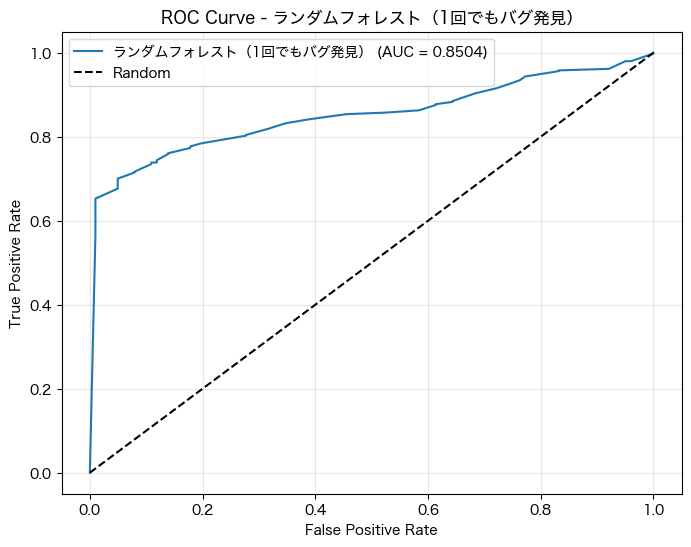

In [1305]:
# ランダムフォレストモデルの訓練と評価（タスク1）
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X1_train, y1_train)

# 予測
y1_pred_rf = rf_model.predict(X1_test)
y1_pred_proba_rf = rf_model.predict_proba(X1_test)[:, 1]

# 評価
rf1_results = evaluate_model(y1_test, y1_pred_rf, y1_pred_proba_rf, "ランダムフォレスト（1回でもバグ発見）", X1_train, y1_train, X1_test, y1_test, rf_model)



【ランダムフォレスト】特徴量重要度（1回でもバグ発見）
       feature  importance
2  cpNum_range    0.575793
1        cpNum    0.237783
3    cpNum_dir    0.099817
0         tree    0.086607


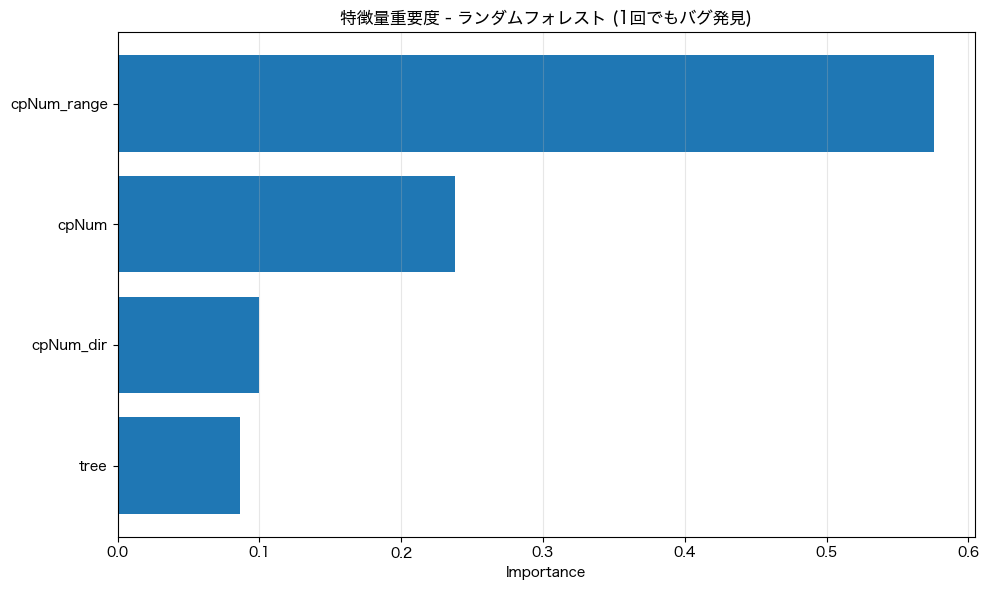

In [1306]:
# ランダムフォレストの特徴量重要度（タスク1）
feature_importance_rf1 = pd.DataFrame({
    'feature': X1.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【ランダムフォレスト】特徴量重要度（1回でもバグ発見）")
print(feature_importance_rf1)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf1['feature'], feature_importance_rf1['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - ランダムフォレスト (1回でもバグ発見)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



【タスク1: 1回でもバグ発見】モデル比較
                決定木  ランダムフォレスト
Accuracy   0.754630   0.824074
Precision  0.975490   0.849758
Recall     0.727605   0.961609
F1-Score   0.833508   0.902230


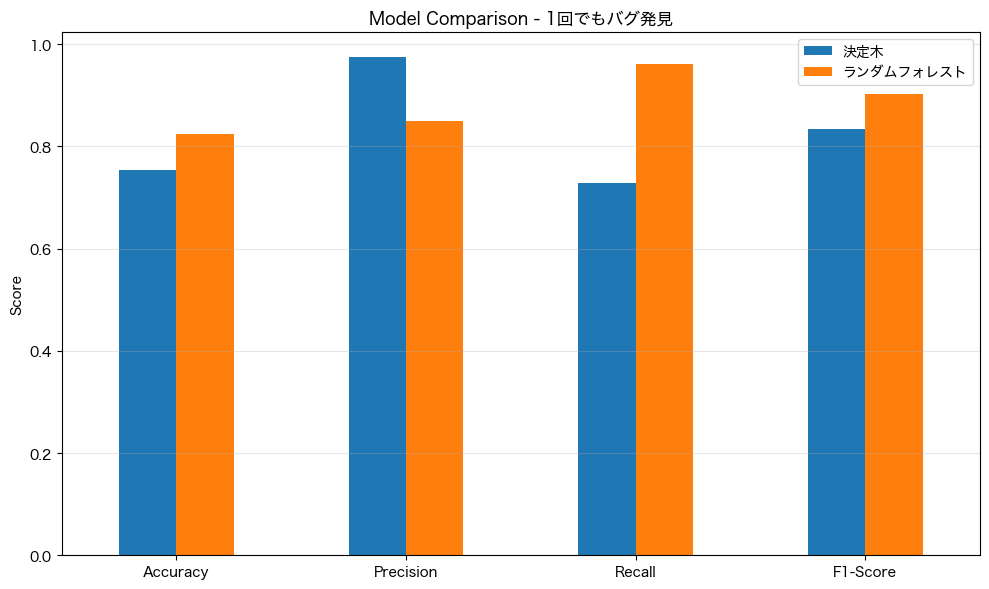

In [1307]:
# タスク1の結果比較
comparison_task1 = pd.DataFrame({
    '決定木': [
        dt1_results['accuracy'],
        dt1_results['precision'],
        dt1_results['recall'],
        dt1_results['f1']
    ],
    'ランダムフォレスト': [
        rf1_results['accuracy'],
        rf1_results['precision'],
        rf1_results['recall'],
        rf1_results['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク1: 1回でもバグ発見】モデル比較")
print(comparison_task1)

# 可視化
comparison_task1.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - 1回でもバグ発見')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## タスク2: 5回実行して5回全てバグ発見の予測


In [1308]:
# タスク2: 5回実行して5回全てバグ発見の予測

# 特徴量と目的変数の準備
X2 = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y2 = df['bug_detected_all']

# 訓練データとテストデータに分割
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

print(f"訓練データ数: {len(X2_train)}")
print(f"テストデータ数: {len(X2_test)}")
print(f"\n訓練データの目的変数分布:")
print(y2_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y2_test.value_counts())


訓練データ数: 1728
テストデータ数: 432

訓練データの目的変数分布:
bug_detected_all
0    1118
1     610
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected_all
0    279
1    153
Name: count, dtype: int64



【決定木（5回全てバグ発見）】評価結果

【混同行列】
[[210  69]
 [ 47 106]]

【評価指標】
Accuracy:  0.7315
Precision: 0.6057
Recall:    0.6928
F1-Score:  0.6463

【ベースラインモデル】
Accuracy:  0.3542
Precision: 0.3542
Recall:    1.0000
F1-Score:  0.5231

（訓練データ・テストデータの正解率を表示するには model, X_train, y_train, X_test, y_test をすべて渡してください）
AUC:       0.8419


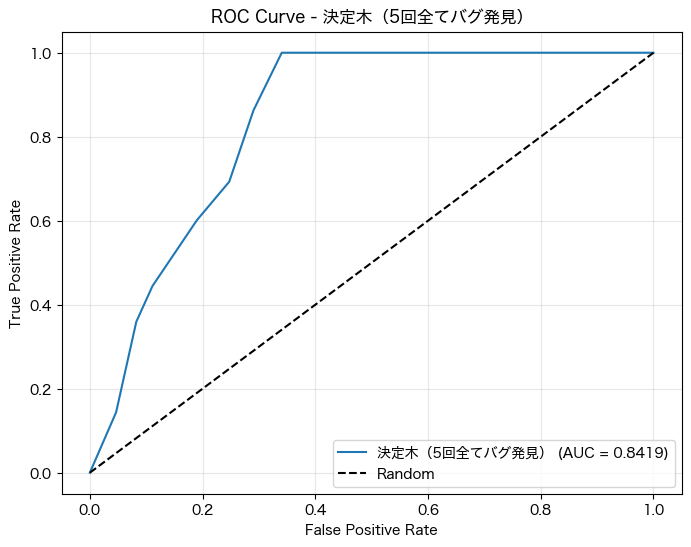

In [1309]:

# 決定木モデルの訓練と評価（タスク2）
dt_model2 = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.05,
    random_state=42
)
dt_model2.fit(X2_train, y2_train)

# 予測
y2_pred_dt = dt_model2.predict(X2_test)
y2_pred_proba_dt = dt_model2.predict_proba(X2_test)[:, 1]

# 評価
dt_results2 = evaluate_model(y2_test, y2_pred_dt, y2_pred_proba_dt, "決定木（5回全てバグ発見）")



【決定木】特徴量重要度（5回全てバグ発見）
       feature  importance
2  cpNum_range    0.630165
1        cpNum    0.345902
0         tree    0.023933
3    cpNum_dir    0.000000


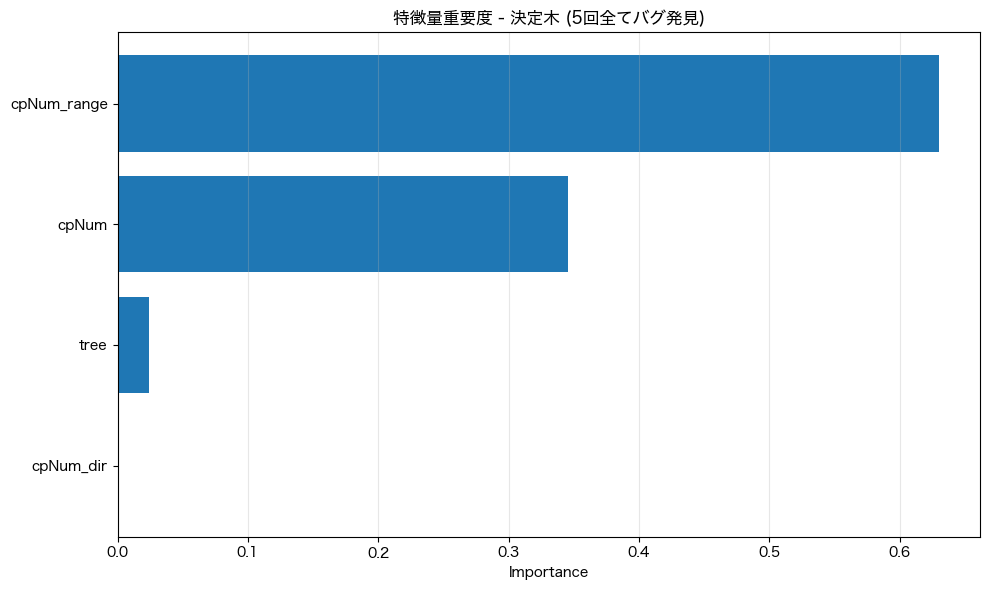

In [1310]:
# 決定木の特徴量重要度（タスク2）
feature_importance_dt2 = pd.DataFrame({
    'feature': X2.columns,
    'importance': dt_model2.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【決定木】特徴量重要度（5回全てバグ発見）")
print(feature_importance_dt2)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_dt2['feature'], feature_importance_dt2['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - 決定木 (5回全てバグ発見)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



【ランダムフォレスト（5回全てバグ発見）】評価結果

【混同行列】
[[201  78]
 [ 35 118]]

【評価指標】
Accuracy:  0.7384
Precision: 0.6020
Recall:    0.7712
F1-Score:  0.6762

【ベースラインモデル】
Accuracy:  0.3542
Precision: 0.3542
Recall:    1.0000
F1-Score:  0.5231

（訓練データ・テストデータの正解率を表示するには model, X_train, y_train, X_test, y_test をすべて渡してください）
AUC:       0.8317


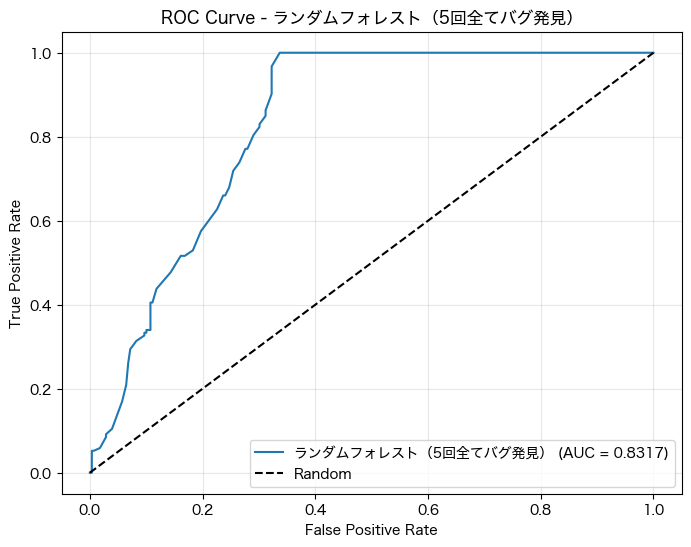

In [1311]:
# ランダムフォレストモデルの訓練と評価（タスク2）
rf_model2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model2.fit(X2_train, y2_train)

# 予測
y2_pred_rf = rf_model2.predict(X2_test)
y2_pred_proba_rf = rf_model2.predict_proba(X2_test)[:, 1]

# 評価
rf_results2 = evaluate_model(y2_test, y2_pred_rf, y2_pred_proba_rf, "ランダムフォレスト（5回全てバグ発見）")



【ランダムフォレスト】特徴量重要度（5回全てバグ発見）
       feature  importance
2  cpNum_range    0.603777
1        cpNum    0.317094
3    cpNum_dir    0.045395
0         tree    0.033734


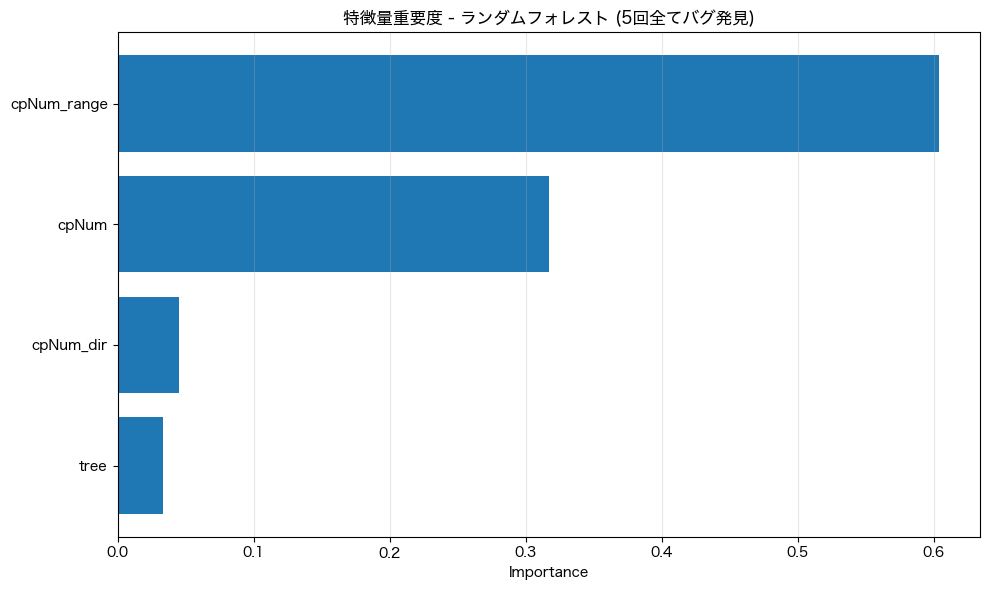

In [1312]:
# ランダムフォレストの特徴量重要度（タスク2）
feature_importance_rf2 = pd.DataFrame({
    'feature': X2.columns,
    'importance': rf_model2.feature_importances_
}).sort_values('importance', ascending=False)

print("\n【ランダムフォレスト】特徴量重要度（5回全てバグ発見）")
print(feature_importance_rf2)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf2['feature'], feature_importance_rf2['importance'])
plt.xlabel('Importance')
plt.title('特徴量重要度 - ランダムフォレスト (5回全てバグ発見)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



【タスク2: 5回全てバグ発見】モデル比較
                決定木  ランダムフォレスト
Accuracy   0.731481   0.738426
Precision  0.605714   0.602041
Recall     0.692810   0.771242
F1-Score   0.646341   0.676218


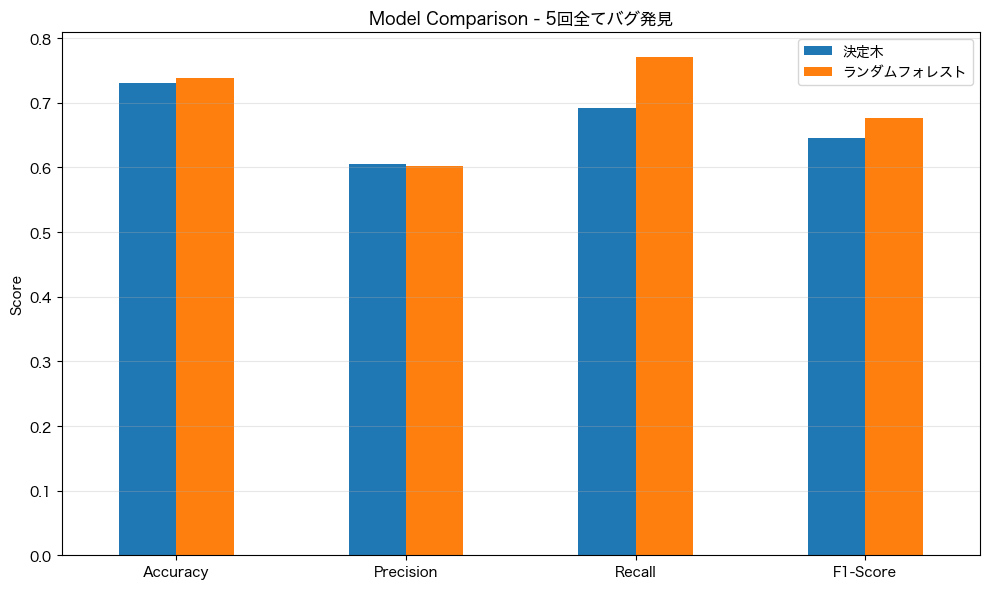

In [1313]:
# タスク2の結果比較
comparison_task2 = pd.DataFrame({
    '決定木': [
        dt_results2['accuracy'],
        dt_results2['precision'],
        dt_results2['recall'],
        dt_results2['f1']
    ],
    'ランダムフォレスト': [
        rf_results2['accuracy'],
        rf_results2['precision'],
        rf_results2['recall'],
        rf_results2['f1']
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n【タスク2: 5回全てバグ発見】モデル比較")
print(comparison_task2)

# 可視化
comparison_task2.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison - 5回全てバグ発見')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
